# Exploring the MHW DB

In [29]:
# imports
import numpy as np
import os
from matplotlib import pyplot as plt

from datetime import date


import pandas
import sqlalchemy
from sqlalchemy.orm import sessionmaker
import iris
import iris.quickplot as qplt

In [2]:
%matplotlib notebook

In [3]:
def match_ids(IDs, match_IDs, require_in_match=True):
    """ Match input IDs to another array of IDs (usually in a table)
    Return the rows aligned with input IDs

    Parameters
    ----------
    IDs : ndarray
    match_IDs : ndarray
    require_in_match : bool, optional
      Require that each of the input IDs occurs within the match_IDs

    Returns
    -------
    rows : ndarray
      Rows in match_IDs that match to IDs, aligned
      -1 if there is no match

    """
    rows = -1 * np.ones_like(IDs).astype(int)
    # Find which IDs are in match_IDs
    in_match = np.in1d(IDs, match_IDs)
    if require_in_match:
        if np.sum(~in_match) > 0:
            raise IOError("qcat.match_ids: One or more input IDs not in match_IDs")
    rows[~in_match] = -1
    #
    IDs_inmatch = IDs[in_match]
    # Find indices of input IDs in meta table -- first instance in meta only!
    xsorted = np.argsort(match_IDs)
    ypos = np.searchsorted(match_IDs, IDs_inmatch, sorter=xsorted)
    indices = xsorted[ypos]
    rows[in_match] = indices
    return rows


# Load up

In [61]:
mhw_file = '/home/xavier/Projects/Oceanography/MHWs/db/mhws_allsky_defaults.db'
tst_file = '/home/xavier/Projects/Oceanography/MHWs/db/test_mhws_allsky.db'

In [62]:
engine = sqlalchemy.create_engine('sqlite:///'+mhw_file)
#engine = sqlalchemy.create_engine('sqlite:///'+tst_file)

In [63]:
connection = engine.connect()
connection

# Table time

In [60]:
pd_tbl = pandas.read_sql_table('', con=engine, 
                               columns=['date', 'lon', 'lat', 'duration' , 
                                        'ievent', 'time_start', 'index'],
                              index_col=0)

ValueError: Table  not found

In [11]:
pd_tbl

,date,lon,lat,duration,ievent,time_start
0,1982-01-01,0.125,-71.375,13,0,723546
1,1982-12-20,0.125,-71.375,33,1,723899
2,1985-01-30,0.125,-71.375,10,2,724671
3,1988-01-10,0.125,-71.375,9,3,725746
4,1991-01-09,0.125,-71.375,52,4,726841
...,...,...,...,...,...,...
45046370,2016-09-16,281.125,64.875,17,104,736223
45046371,2016-10-14,281.125,64.875,7,105,736251
45046372,2017-09-17,281.125,64.875,7,106,736589
45046373,2019-08-19,281.125,64.875,43,107,737290


In [226]:
sidx = []
eidx = []
counter = 0
for kk, lon,lat in zip(range(len(pd_tbl)), pd_tbl['lon'], pd_tbl['lat']):
    newc = '{:0.3f}_{:0.3f}'.format(lon, lat)
    if kk > 0 and newc != sidx[-1]:
        counter = 0
    elif kk>0:
        counter += 1
    sidx.append(newc)
    eidx.append(counter)

In [227]:
pd_tbl['lon-lat'] = sidx
#pd_tbl['eidx'] = eidx

In [228]:
pd_tbl

,date,lon,lat,duration,ievent,time_start,lon-lat
0,1982-01-01,0.125,-71.375,13,0,723546,0.125_-71.375
1,1982-12-20,0.125,-71.375,33,1,723899,0.125_-71.375
2,1985-01-30,0.125,-71.375,10,2,724671,0.125_-71.375
3,1988-01-10,0.125,-71.375,9,3,725746,0.125_-71.375
4,1991-01-09,0.125,-71.375,52,4,726841,0.125_-71.375
...,...,...,...,...,...,...,...
134063,2018-02-11,0.875,-42.625,6,73,736736,0.875_-42.625
134064,2018-03-03,0.875,-42.625,23,74,736756,0.875_-42.625
134065,2018-03-29,0.875,-42.625,63,75,736782,0.875_-42.625
134066,2018-06-19,0.875,-42.625,7,76,736864,0.875_-42.625


In [229]:
len(np.unique(pd_tbl['lon-lat']))

1550

# Make a Cube

## Coords from an existing

In [230]:
noaa_path = '/home/xavier/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/'

In [231]:
file_1982 = os.path.join(noaa_path, 'sst.day.mean.1982.nc')
cubes_1982 = iris.load(file_1982)
sst_1982 = cubes_1982[0]

In [232]:
lat_coord = sst_1982.coord('latitude')
lon_coord = sst_1982.coord('longitude')

## Number of events

In [233]:
ulats = np.unique(pd_tbl['lat'])
ulons = np.unique(pd_tbl['lon'])

In [234]:
#lat_coord.points

In [235]:
i_idx = match_ids(pd_tbl['lat'], lat_coord.points, require_in_match=True)
j_idx = match_ids(pd_tbl['lon'], lon_coord.points, require_in_match=True)
#i_idx, j_idx

In [236]:
n_events  = np.zeros((lat_coord.shape[0], lon_coord.shape[0]))
for ii, jj in zip(i_idx, j_idx):
    n_events[ii,jj] += 1

In [237]:
cube = iris.cube.Cube(n_events/38., var_name='N_events',
                                     dim_coords_and_dims=[(lat_coord, 0),
                                                          (lon_coord, 1)])

In [238]:
cube

N Events (unknown),latitude,longitude
Shape,720,1440
Dimension coordinates,,
latitude,x,-
longitude,-,x


# Plot

## Contours

In [239]:
np.max(cube.data)

3.6578947368421053

In [240]:
np.sum(cube.data > 0.) / cube.data.size

0.0014949845679012345

In [241]:
cube.data.size

1036800

<IPython.core.display.Javascript object>


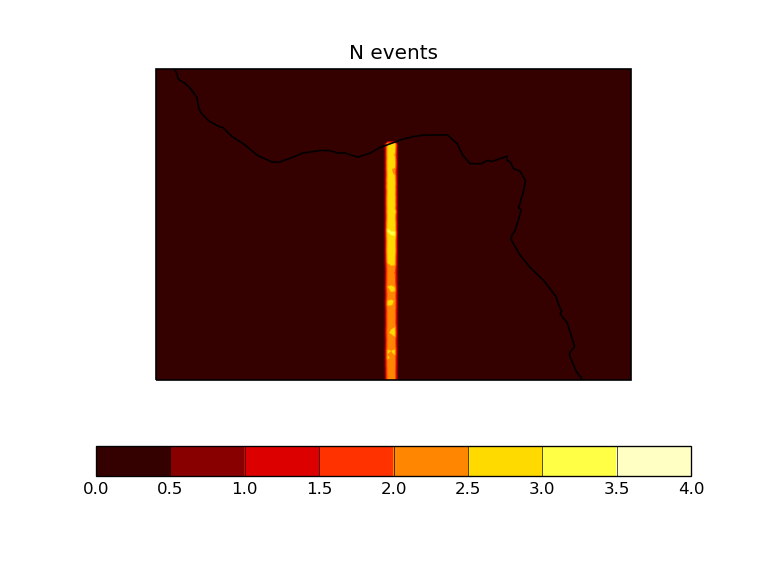

In [246]:
# Draw the contour with 25 levels.
cm = plt.get_cmap('hot')

qplt.contourf(cube, cmap=cm)#,5, vmin=0, vmax=20)#, 5)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

## Histogram

In [243]:
hist, edges = np.histogram(n_events, 50, range=(1., 120))

<IPython.core.display.Javascript object>


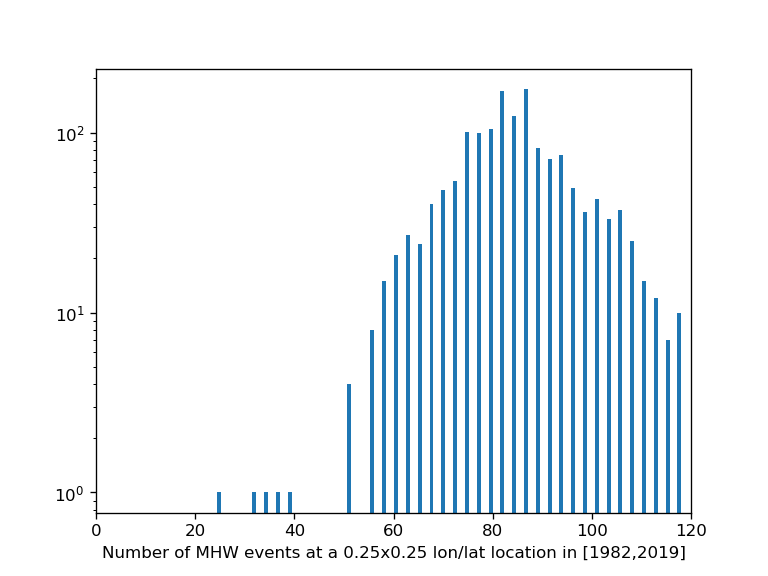

In [245]:
plt.clf()
ax = plt.gca()
ax.bar(edges[:-1], hist)
ax.set_xlim(0., 120)
ax.set_yscale('log')
#
ax.set_xlabel('Number of MHW events at a 0.25x0.25 lon/lat location in [1982,2019]')
#
plt.show()

In [205]:
H_duration, bins_duration = np.histogram(pd_tbl['duration'], 50)#, range=(1., 120))

<IPython.core.display.Javascript object>


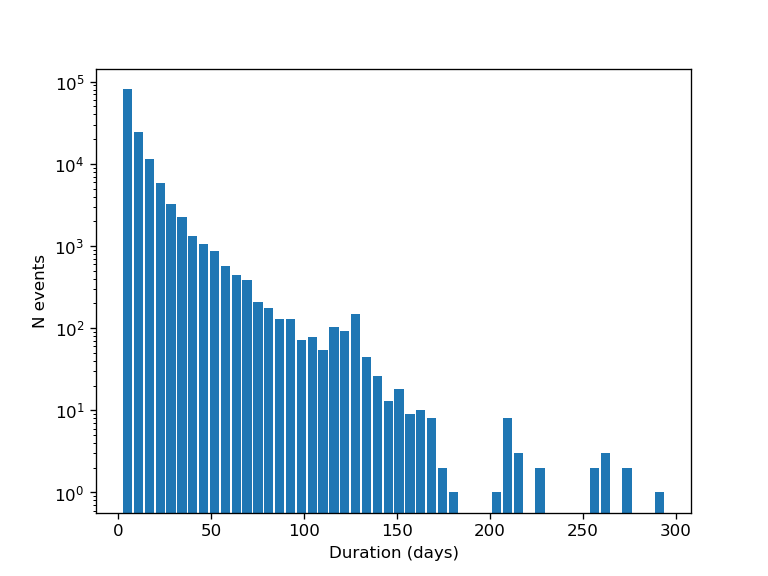

In [206]:
plt.clf()
ax = plt.gca()
ax.bar(bins_duration[:-1], H_duration, width=5)
#ax.set_xlim(0., 120)
ax.set_yscale('log')
#
ax.set_xlabel('Duration (days)')
ax.set_ylabel('N events')
#
plt.show()

# Time series

In [207]:
pd_tbl

,date,lon,lat,duration,ievent,time_start,lon-lat
0,1982-01-01,0.125,-71.375,13,0,723546,0.125_-71.375
1,1982-12-20,0.125,-71.375,33,1,723899,0.125_-71.375
2,1985-01-30,0.125,-71.375,10,2,724671,0.125_-71.375
3,1988-01-10,0.125,-71.375,9,3,725746,0.125_-71.375
4,1991-01-09,0.125,-71.375,52,4,726841,0.125_-71.375
...,...,...,...,...,...,...,...
134063,2018-02-11,0.875,-42.625,6,73,736736,0.875_-42.625
134064,2018-03-03,0.875,-42.625,23,74,736756,0.875_-42.625
134065,2018-03-29,0.875,-42.625,63,75,736782,0.875_-42.625
134066,2018-06-19,0.875,-42.625,7,76,736864,0.875_-42.625


## Grab the 'hot spot'

In [208]:
hot_idx = np.where(n_events == np.max(n_events))
hot_idx

(array([647]), array([0]))

In [209]:
n_events.shape

(720, 1440)

In [214]:
lat_coord[hot_idx[0]], lon_coord[hot_idx[1]]

(DimCoord(array([71.875], dtype=float32), standard_name='latitude', units=Unit('degrees'), long_name='Latitude', var_name='lat', attributes={'actual_range': array([-89.875,  89.875], dtype=float32)}),
 DimCoord(array([0.125], dtype=float32), standard_name='longitude', units=Unit('degrees'), long_name='Longitude', var_name='lon', attributes={'actual_range': array([1.25000e-01, 3.59875e+02], dtype=float32)}))

In [217]:
most_events = pd_tbl[(pd_tbl['lon']==0.125) & (pd_tbl['lat']==71.875)]

In [218]:
most_events = most_events.set_index('date')
most_events

,lon,lat,duration,ievent,time_start,lon-lat
date,,,,,,
1984-01-31,0.125,71.875,10,0,724306,0.125_71.875
1985-03-26,0.125,71.875,6,1,724726,0.125_71.875
1988-03-31,0.125,71.875,13,2,725827,0.125_71.875
1990-07-31,0.125,71.875,5,3,726679,0.125_71.875
1990-08-23,0.125,71.875,17,4,726702,0.125_71.875
...,...,...,...,...,...,...
2019-04-24,0.125,71.875,6,134,737173,0.125_71.875
2019-07-16,0.125,71.875,12,135,737256,0.125_71.875
2019-07-31,0.125,71.875,12,136,737271,0.125_71.875


<IPython.core.display.Javascript object>


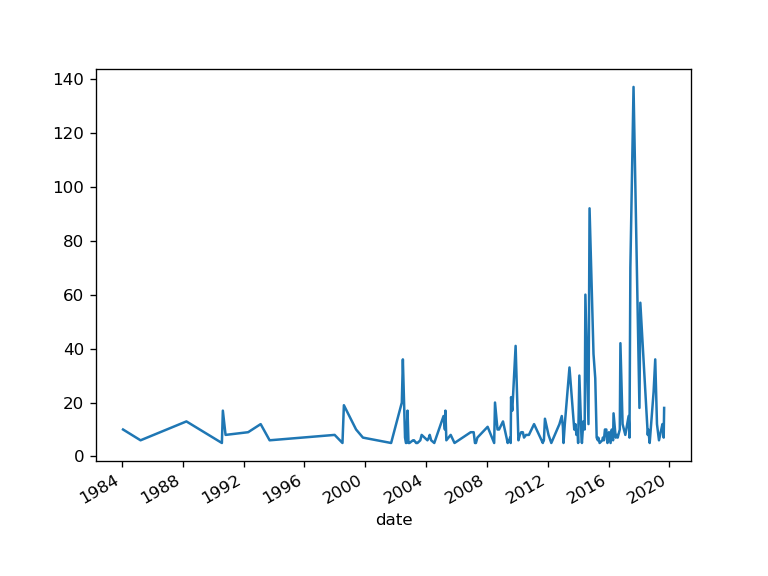

In [219]:
most_events['duration'].plot()

----

In [36]:
np.sum(n_events)

622923.0

----

# SQL query

In [15]:
metadata = sqlalchemy.MetaData()
mhw_tbl = sqlalchemy.Table('MHW_Events', metadata, autoload=True, autoload_with=engine)

In [16]:
mhw_tbl

Table('MHW_Events', MetaData(bind=None), Column('index', BIGINT(), table=<MHW_Events>), Column('time_start', INTEGER(), table=<MHW_Events>), Column('time_end', INTEGER(), table=<MHW_Events>), Column('time_peak', INTEGER(), table=<MHW_Events>), Column('duration', INTEGER(), table=<MHW_Events>), Column('duration_moderate', INTEGER(), table=<MHW_Events>), Column('duration_strong', INTEGER(), table=<MHW_Events>), Column('duration_severe', INTEGER(), table=<MHW_Events>), Column('duration_extreme', INTEGER(), table=<MHW_Events>), Column('ievent', BIGINT(), table=<MHW_Events>), Column('date', DATETIME(), table=<MHW_Events>), Column('category', TEXT(), table=<MHW_Events>), Column('lat', FLOAT(), table=<MHW_Events>), Column('lon', FLOAT(), table=<MHW_Events>), Column('intensity_max', FLOAT(), table=<MHW_Events>), Column('intensity_mean', FLOAT(), table=<MHW_Events>), Column('intensity_var', FLOAT(), table=<MHW_Events>), Column('intensity_cumulative', FLOAT(), table=<MHW_Events>), Column('intens

In [69]:
query = sqlalchemy.select([mhw_tbl]).where(sqlalchemy.and_(
    mhw_tbl.columns.ievent == 108, mhw_tbl.columns.time_start == 737341, mhw_tbl.columns.duration == 14))
query2 = sqlalchemy.select([mhw_tbl]).where(mhw_tbl.columns.index == 10)

In [70]:
result = connection.execute(query).fetchall()

In [73]:
last = result[-1]
last

(3254, 737341, 737354, 737343, 14, 14, 0, 0, 0, 108, datetime.datetime(2019, 10, 9, 0, 0), 'Moderate', 64.875, 281.125, 1.309165120124817, 1.1455113887786865, 0.11705464124679565, 16.037158966064453, 0.5546451807022095, 0.949999988079071, 0.36944928765296936, 0.7099999785423279, 0.12052048742771149, 0.13228756189346313, 5.172290325164795, 9.9399995803833, 0.3190819025039673, 0.05230056494474411)

In [75]:
last[12:14]

(64.875, 281.125)

In [31]:
Session = sessionmaker(bind=engine)
session = Session()

In [44]:
session.query(mhw_tbl.__name__).get(1)

AttributeError: 'Table' object has no attribute '__name__'

In [34]:
rows = session.query(sqlalchemy.func.count(mhw_tbl.columns.index)).scalar()

In [35]:
rows

45046375

In [51]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

Base = automap_base()
Base.prepare(engine, reflect=True)

#MHW = Base.classes.MHW_Events
#session = Session(engine)

#res = session.query(Users).first()

In [56]:
metadata.reflect(engine)#, only=['MWH_Events'])

# ... or just define our own Table objects with it (or combine both)
#Table('user_order', metadata,
#                Column('id', Integer, primary_key=True),
#                Column('user_id', ForeignKey('user.id'))
#            )

# we can then produce a set of mappings from this MetaData.
Base = automap_base(metadata=metadata)

# calling prepare() just sets up mapped classes and relationships.
Base.prepare()

In [58]:
Base.classes